In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import os

In [37]:
cwd = os.getcwd()
fp = os.path.join(cwd,'data/HCP500_rfMRI_motion.txt')
hcp=np.loadtxt(fp)
fp = os.path.join(cwd,'data/mean_FDs.txt')
abcd=np.loadtxt(fp)

# for ABCD, change nan --> 0
abcd[np.isnan(abcd)]=0

In [38]:
# mean and SD
hcp_mu = np.mean(hcp)
hcp_sigma = np.std(hcp)

abcd_mu = np.mean(abcd)
abcd_sigma = np.std(abcd)

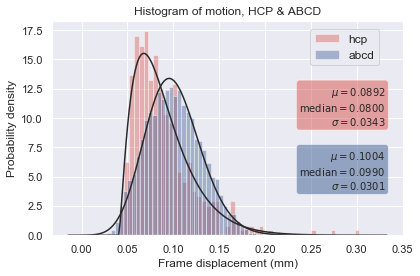

In [39]:
bins=50
fig, ax = plt.subplots()

# Call the sns.set() function 
sns.set()
sns.distplot(hcp,bins=bins,norm_hist=True,label='hcp',fit=stats.gamma,kde=False,color=sns.xkcd_rgb["pale red"])
sns.distplot(abcd,bins=bins,norm_hist=True,label='abcd',fit=stats.gamma,kde=False,color=sns.xkcd_rgb["denim blue"])

# plt.axvline(np.median(hcp), linestyle='--',color=sns.xkcd_rgb["pale red"])
# plt.axvline(np.median(abcd), linestyle='--',color=sns.xkcd_rgb["denim blue"])

plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.99),fontsize=12)

ax.set_xlabel('Frame displacement (mm)')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of motion, HCP & ABCD')

textstr1 = '\n'.join((
    r'$\mu=%.4f$' % (np.mean(hcp), ),
    r'$\mathrm{median}=%.4f$' % (np.median(hcp), ),
    r'$\sigma=%.4f$' % (np.std(hcp), )))

textstr2 = '\n'.join((
    r'$\mu=%.4f$' % (np.mean(abcd), ),
    r'$\mathrm{median}=%.4f$' % (np.median(abcd), ),
    r'$\sigma=%.4f$' % (np.std(abcd), )))

props1 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["pale red"], alpha=0.5)
props2 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["denim blue"], alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.7, textstr1, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props1)
# place a text box in upper left in axes coords
ax.text(0.95, 0.4, textstr2, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props2)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [40]:
stats.ks_2samp(hcp, abcd)

Ks_2sampResult(statistic=0.23487136172141834, pvalue=2.0415692464307362e-21)

In [41]:
# The above statistical test concludes that the distributions ARE DIFFERENT --> we cannot use all subjects from each.
# The above distribution was drawn with ALL ABCD subjects with available timeseries, regardless of how much "good" scan time they have. We will be using >10min scan time as the cutoff.

In [99]:
# Lets find out how many subjects have >10min scan time.
fp = os.path.join(cwd,'data/motion_summary_data.csv')

dtype_dict={
    'sub': 'O',
    'total_frame_count': 'int32',
    'remaining_frame_count': 'UInt32',
    'remaining_seconds': 'f8',
    'remaining_frame_mean_FD': 'f8'
}

msd = pd.read_csv(fp, sep=',')
msd

,sub,total_frame_count,remaining_frame_count,remaining_seconds,remaining_frame_mean_FD
0,NDARINV003RTV85,1532,1272,1017.6,0.089856
1,NDARINV007W6H7B,1520,1492,1193.6,0.046332
2,NDARINV00BD7VDC,1532,1182,945.6,0.094341
3,NDARINV00CY2MDM,1532,916,732.8,0.136844
4,NDARINV00J52GPG,1532,1339,1071.2,0.126292
5,NDARINV00LH735Y,1532,1502,1201.6,0.077002
6,NDARINV00LJVZK2,1532,196,156.8,0.148578
7,NDARINV00NPMHND,1532,1489,1191.2,0.090999
8,NDARINV00R4TXET,1149,1109,887.2,0.069646
9,NDARINV00U4FTRU,1520,1341,1072.8,0.100967


In [90]:
print(len(msd[msd['remaining_seconds'].ge(600)]))
print(len(msd['sub']))
print(len(msd[(msd['remaining_seconds']>600)])/len(msd['sub']))

7215
8814
0.8176764238711142


In [91]:
# This is a pretty good sample size, compared to original of 8814 (81%)

In [92]:
# Now, lets recreate the histograms for analysis
# abcd2=list(msd[])
msdfilt=msd[(msd['remaining_seconds']>600)]
abcd2 = msdfilt['remaining_frame_mean_FD'].tolist()

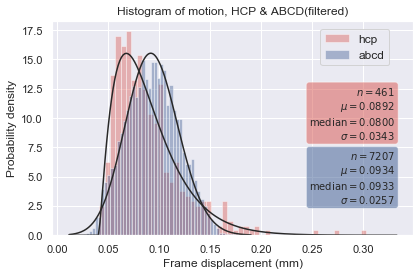

In [97]:
bins=50
fig, ax = plt.subplots()

# Call the sns.set() function 
sns.set()
sns.distplot(hcp,bins=bins,norm_hist=True,label='hcp',fit=stats.gamma,kde=False,color=sns.xkcd_rgb["pale red"])
sns.distplot(abcd2,bins=bins,norm_hist=True,label='abcd',fit=stats.gamma,kde=False,color=sns.xkcd_rgb["denim blue"])

# plt.axvline(np.median(hcp), linestyle='--',color=sns.xkcd_rgb["pale red"])
# plt.axvline(np.median(abcd), linestyle='--',color=sns.xkcd_rgb["denim blue"])

plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.99),fontsize=12)

ax.set_xlabel('Frame displacement (mm)')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of motion, HCP & ABCD(filtered)')

textstr1 = '\n'.join((
    r'$n=%d$' % (len(hcp), ),
    r'$\mu=%.4f$' % (np.mean(hcp), ),
    r'$\mathrm{median}=%.4f$' % (np.median(hcp), ),
    r'$\sigma=%.4f$' % (np.std(hcp), )))

textstr2 = '\n'.join((
    r'$n=%d$' % (len(abcd2), ),
    r'$\mu=%.4f$' % (np.mean(abcd2), ),
    r'$\mathrm{median}=%.4f$' % (np.median(abcd2), ),
    r'$\sigma=%.4f$' % (np.std(abcd2), )))

props1 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["pale red"], alpha=0.5)
props2 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["denim blue"], alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.7, textstr1, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props1)
# place a text box in upper left in axes coords
ax.text(0.95, 0.4, textstr2, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props2)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(cwd,'data/hcp_abcd_histogram.png'),dpi=600)

In [95]:

stats.ks_2samp(hcp, abcd2)

Ks_2sampResult(statistic=0.18516494117101745, pvalue=2.498042964939321e-13)

In [ ]:
# Finally, export two files:
# 1. list of subjects to include in the CCA analysis